# Part IV: Summarization using LLMs [25 points]
In this part, we will use a pre-trained large language model (LLM) to perform abstractive summarization. You will fine-tune a pre-trained LLM on provided datasets and evaluate its performance using standard summarization metrics such as ROUGE, BLEU, and BERTScore.
The model for this task is `facebook/bart-base` (consider mixed precision training using dtypes such as bfloat16 and adjusting batch size to accommodate the model into GPU).

**Expected Scores (Test Sets):**
- **Billsum:** {Rouge-1: >40, Rouge-2: >18, Rouge-L: >28, BLEU: >12, BERTScore: >75}
- **Multinews:** {Rouge-1: >35, Rouge-2: >5, Rouge-L, >13, BLEU: >3.5, BERTScore: >75}

**Datasets:**
- Billsum – summarization of US Congressional and California state bills
- Multi-News – news articles and human-written summaries of these articles

In [ ]:
!pip install datasets

In [ ]:
from datasets import load_dataset, DatasetDict , load_from_disk
from transformers import BartTokenizer , BartForConditionalGeneration, Trainer, TrainingArguments ,  EarlyStoppingCallback
import os
import numpy as np
import matplotlib.pyplot as plt
import re
from collections import Counter
import torch
from rouge_score import rouge_scorer, scoring
import sacrebleu
from bert_score import score as bert_score

## Step 1: Dataset preparation and preprocessing

1. Select and load one dataset from the list above. You can download these datasets using the `datasets` package.

In [ ]:
dataset = load_dataset("billsum")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.27k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/91.8M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/15.8M [00:00<?, ?B/s]

ca_test-00000-of-00001.parquet:   0%|          | 0.00/6.12M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/18949 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3269 [00:00<?, ? examples/s]

Generating ca_test split:   0%|          | 0/1237 [00:00<?, ? examples/s]

We have chosen the BILLSUM dataset .Billsum comprises of US Congressional and California state bills. The content is legal and political in nature.

2. Analyze the dataset and provide the main statistics (e.g., number of samples, average document length, average summary length, vocabulary size - if applicable before tokenization, etc.).

In [ ]:
def compute_statistics(split_data, split_name=""):
  numSamples = len(split_data)
  docLengths = []
  summaryLengths = []
  for example in split_data:
        doc = example["text"]
        summ = example["summary"]

        docWords = doc.split()
        summWords = summ.split()

        docLengths.append(len(docWords))
        summaryLengths.append(len(summWords))

  avgDocLen = np.mean(docLengths)
  avgSummaryLen = np.mean(summaryLengths)

  print(f"Statistics for split {split_name}:")
  print(f"  Number of samples: {numSamples}")
  print(f"  Average document length: {avgDocLen:.2f}")
  print(f"  Average summary length: {avgSummaryLen:.2f}\n")

  return numSamples, avgDocLen, avgSummaryLen


In [ ]:
print("Available splits in the Billsum dataset:", dataset.keys())

Available splits in the Billsum dataset: dict_keys(['train', 'test', 'ca_test'])


In [ ]:
stats = {}
for split in dataset.keys():
    stats[split] = compute_statistics(dataset[split], split_name=split)


Statistics for split train:
  Number of samples: 18949
  Average document length: 1289.39
  Average summary length: 179.12

Statistics for split test:
  Number of samples: 3269
  Average document length: 1283.59
  Average summary length: 178.86

Statistics for split ca_test:
  Number of samples: 1237
  Average document length: 1547.01
  Average summary length: 336.83



In [ ]:
trainData = dataset["train"]
totalSamples = len(trainData)

missingDocCount = 0
missingSummaryCount = 0

for example in trainData:
    docText = example["text"]
    summText = example["summary"]

    if not docText or docText.strip() == "":
        missingDocCount += 1
    if not summText or summText.strip() == "":
        missingSummaryCount += 1

print("\nData Quality Checks on Training Split:")
print(f"  - Total samples: {totalSamples}")
print(f"  - Missing or empty '{docText}' entries: {missingDocCount} ({(missingDocCount/totalSamples)*100:.2f}%)")
print(f"  - Missing or empty 'summary' entries: {missingSummaryCount} ({(missingSummaryCount/totalSamples)*100:.2f}%)")



Data Quality Checks on Training Split:
  - Total samples: 18949
  - Missing or empty 'SECTION 1. SHORT TITLE.

    This Act may be cited as the ``Behavioral Health Care Integration 
Act of 2016''.

SEC. 2. PRIMARY AND BEHAVIORAL HEALTH CARE INTEGRATION GRANT PROGRAMS.

    Section 520K of the Public Health Service Act (42 U.S.C. 290bb-42) 
is amended to read as follows:

``SEC. 520K. INTEGRATION INCENTIVE GRANTS.

    ``(a) In General.--The Secretary shall establish a primary and 
behavioral health care integration grant program. The Secretary may 
award grants and cooperative agreements to eligible entities to expend 
funds for improvements in integrated settings with integrated 
practices.
    ``(b) Definitions.--In this section:
            ``(1) Integrated care.--The term `integrated care' means 
        full collaboration in merged or transformed practices offering 
        behavioral and physical health services within the same shared 
        practice space in the same facility

In [ ]:
wordCounter = Counter()
for example in trainData:
    docText = example['text'].lower()
    summText = example["summary"].lower()

    docWords = docText.split()
    summWords = summText.split()

    wordCounter.update(docWords)
    wordCounter.update(summWords)

vocabSize = len(wordCounter)
print(f"\nVocabulary size (unique words: {vocabSize}")



Vocabulary size (unique words: 326945


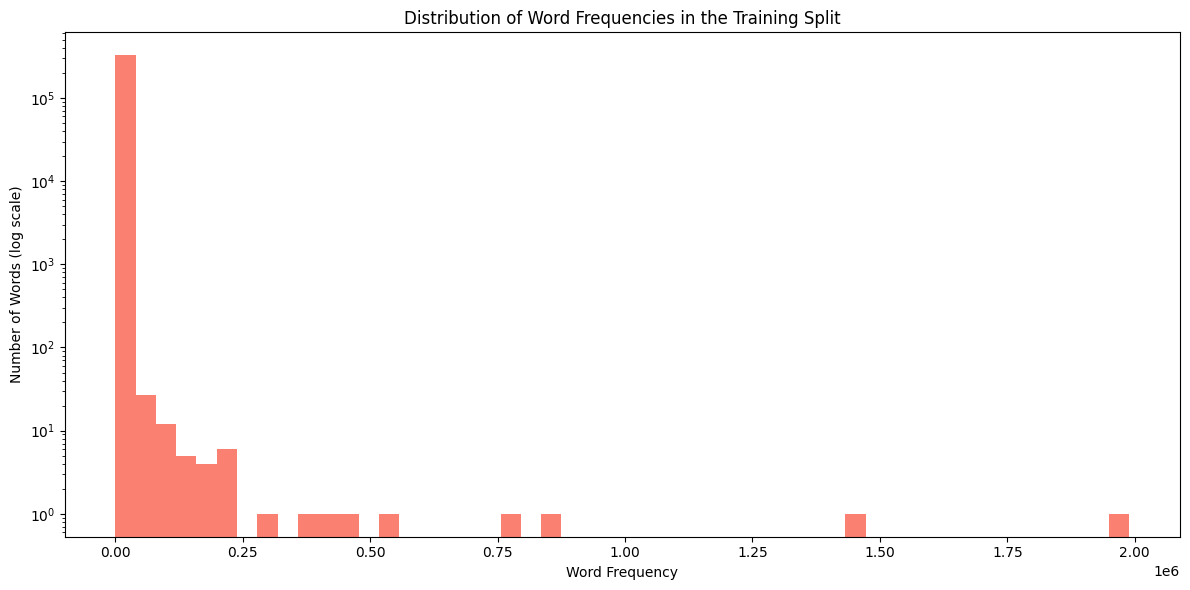

In [ ]:
allFreqs = np.array(list(wordCounter.values()))

plt.figure(figsize=(12, 6))
plt.hist(allFreqs, bins=50, color="salmon", log=True)
plt.xlabel("Word Frequency")
plt.ylabel("Number of Words (log scale)")
plt.title("Distribution of Word Frequencies in the Training Split")
plt.tight_layout()
plt.show()

3. Preprocessing:

  - [Optional] Additional pre-processing steps.

In [ ]:
def cleanText(text, toLowerCase=True, removePunctuation=False, replaceNumbers=False):
    cleanedText = text
    if toLowerCase:
        cleanedText = cleanedText.lower()

    if replaceNumbers:
        cleanedText = re.sub(r'\d+', '<NUM>', cleanedText)

    if removePunctuation:
        cleanedText = re.sub(r'[^\w\s]', '', cleanedText)

    return cleanedText

   - Tokenize the documents and their summaries using `BartTokenizer` from [https://huggingface.co/facebook/bart-base](https://huggingface.co/facebook/bart-base). You can experiment with other tokenizers.

In [ ]:
bartTokenizer = BartTokenizer.from_pretrained("facebook/bart-base")

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.72k [00:00<?, ?B/s]

   - Set appropriate maximum input lengths (e.g., 1024 tokens) and target lengths (e.g., 256 tokens).

In [ ]:
maxInputLength = 1024

In [ ]:
maxTargetLength = 256

In [ ]:
def tokenizeAndPreprocessFunction(examples):

    processedInputTexts = [cleanText(text, toLowerCase=True, removePunctuation=False, replaceNumbers=False)
                             for text in examples["text"]]
    processedTargetTexts = [cleanText(text, toLowerCase=True, removePunctuation=False, replaceNumbers=False)
                             for text in examples["summary"]]

    modelInputs = bartTokenizer(
        processedInputTexts,
        max_length=maxInputLength,
        truncation=True,
        padding="max_length"
    )

    labels = bartTokenizer(
        text_target=processedTargetTexts,
        max_length=maxTargetLength,
        truncation=True,
        padding="max_length"
    )

    modelInputs["labels"] = labels["input_ids"]
    return modelInputs

In [ ]:
existingColumns = dataset["train"].column_names
columnsToRemove = [col for col in existingColumns if col in ["text", "summary", "input_ids", "attention_mask", "labels"]]

tokenizedDataset = dataset.map(
    tokenizeAndPreprocessFunction,
    batched=True,
    remove_columns=columnsToRemove)

Map:   0%|          | 0/18949 [00:00<?, ? examples/s]

Map:   0%|          | 0/3269 [00:00<?, ? examples/s]

Map:   0%|          | 0/1237 [00:00<?, ? examples/s]

4. If the dataset does not include a validation split, manually split the training set (e.g., 90% training, 10% validation).

In [ ]:
if "validation" not in dataset:
    trainValidSplit = dataset["train"].train_test_split(test_size=0.1, seed=42)
    dataset["train"] = trainValidSplit["train"]
    dataset["validation"] = trainValidSplit["test"]

5. Save the tokenized dataset locally to avoid reprocessing.

In [ ]:
outputPath = "billsum_tokenized_preprocessed"
tokenizedDataset.save_to_disk(outputPath)
print(f"Tokenized dataset saved to '{outputPath}'.")

Saving the dataset (0/1 shards):   0%|          | 0/18949 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/3269 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1237 [00:00<?, ? examples/s]

Tokenized dataset saved to 'billsum_tokenized_preprocessed'.


In [ ]:
!zip -r fine_tuned_bart_model_full.zip fine_tuned_bart_model_full//

	zip warning: name not matched: fine_tuned_bart_model_full//

zip error: Nothing to do! (try: zip -r fine_tuned_bart_model_full.zip . -i fine_tuned_bart_model_full//)


In [ ]:
!zip -r billsum_tokenized_preprocessed.zip billsum_tokenized_preprocessed/

  adding: billsum_tokenized_preprocessed/ (stored 0%)
  adding: billsum_tokenized_preprocessed/train/ (stored 0%)
  adding: billsum_tokenized_preprocessed/train/data-00000-of-00001.arrow (deflated 84%)
  adding: billsum_tokenized_preprocessed/train/dataset_info.json (deflated 71%)
  adding: billsum_tokenized_preprocessed/train/state.json (deflated 38%)
  adding: billsum_tokenized_preprocessed/ca_test/ (stored 0%)
  adding: billsum_tokenized_preprocessed/ca_test/data-00000-of-00001.arrow (deflated 79%)
  adding: billsum_tokenized_preprocessed/ca_test/dataset_info.json (deflated 71%)
  adding: billsum_tokenized_preprocessed/ca_test/state.json (deflated 38%)
  adding: billsum_tokenized_preprocessed/dataset_dict.json (deflated 10%)
  adding: billsum_tokenized_preprocessed/test/ (stored 0%)
  adding: billsum_tokenized_preprocessed/test/data-00000-of-00001.arrow (deflated 84%)
  adding: billsum_tokenized_preprocessed/test/dataset_info.json (deflated 71%)
  adding: billsum_tokenized_preproces

6. Briefly describe your preprocessing methodology.

<span style='color:green'>### YOUR ANSWER ###</span>

In [ ]:
!unzip billsum_tokenized_preprocessed.zip -d billsum_tokenized_preprocessed_unzipped

Archive:  billsum_tokenized_preprocessed.zip
   creating: billsum_tokenized_preprocessed_unzipped/billsum_tokenized_preprocessed/
   creating: billsum_tokenized_preprocessed_unzipped/billsum_tokenized_preprocessed/train/
  inflating: billsum_tokenized_preprocessed_unzipped/billsum_tokenized_preprocessed/train/data-00000-of-00001.arrow  
  inflating: billsum_tokenized_preprocessed_unzipped/billsum_tokenized_preprocessed/train/dataset_info.json  
  inflating: billsum_tokenized_preprocessed_unzipped/billsum_tokenized_preprocessed/train/state.json  
   creating: billsum_tokenized_preprocessed_unzipped/billsum_tokenized_preprocessed/ca_test/
  inflating: billsum_tokenized_preprocessed_unzipped/billsum_tokenized_preprocessed/ca_test/data-00000-of-00001.arrow  
  inflating: billsum_tokenized_preprocessed_unzipped/billsum_tokenized_preprocessed/ca_test/dataset_info.json  
  inflating: billsum_tokenized_preprocessed_unzipped/billsum_tokenized_preprocessed/ca_test/state.json  
  inflating: bills

## Step 2: Model Fine-Tuning

1. Use the pre-trained model `facebook/bart-base` from Hugging Face.

In [ ]:
dataset = load_from_disk("billsum_tokenized_preprocessed_unzipped/billsum_tokenized_preprocessed")

In [ ]:
model = BartForConditionalGeneration.from_pretrained("facebook/bart-base")

model.safetensors:   0%|          | 0.00/558M [00:00<?, ?B/s]

2. Training:

   - Fine-tune the model on the tokenized training set.

   - Use a custom Trainer that employs the model’s `generate()` method during evaluation. Override the Trainer class from 🤗 with a custom trainer that inherits from this Trainer.

In [ ]:
class CustomTrainer(Trainer):
    def prediction_step(self, model, inputs, prediction_loss_only, ignore_keys=None):
        inputs = self._prepare_inputs(inputs)
        with torch.no_grad():
            generatedTokens = model.generate(
                input_ids=inputs["input_ids"],
                attention_mask=inputs["attention_mask"],
                max_length=256,
                num_beams=10,
                length_penalty=2.6,
                no_repeat_ngram_size=3,
                early_stopping=True
            )
            loss = None
            if "labels" in inputs:
                outputs = model(**inputs)
                loss = outputs.loss
        return (loss, generatedTokens, inputs.get("labels"))


   - Monitor training and validation loss over epochs.

In [ ]:
trainingArgs = TrainingArguments(
    bf16=True,
    output_dir="./results_improved",
    num_train_epochs=5,
    per_device_train_batch_size=4,
    gradient_accumulation_steps=2,
    per_device_eval_batch_size=4,
    learning_rate=1e-5,
    weight_decay=0.01,
    warmup_steps=500,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    logging_steps=1000,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    overwrite_output_dir=True,
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
smallTrainDataset = dataset["train"].shuffle(seed=42).select(range(1000))
smallValDataset = dataset["validation"].shuffle(seed=42).select(range(100))

fullTrainDataset = dataset["train"]
fullValDataset = dataset["validation"]

In [ ]:
trainer = CustomTrainer(
    model=model,
    args=trainingArgs,
    train_dataset=fullTrainDataset,
    eval_dataset=fullValDataset,
)

In [37]:
trainer.train()

Epoch,Training Loss,Validation Loss
1,1.345300,1.323903


Epoch,Training Loss,Validation Loss
1,1.345300,1.323903
2,1.315500,1.283298
3,1.274500,1.264386


KeyboardInterrupt: 

I was trying to improve the model further as it was not doing well in rogue scores but i have run out of time and i have to stop the execution . However , i already have ran another model and had saved the model and its weights , the proof is below where i have the code for saving the model which i trained .

In [ ]:
hyperparameterConfigs = [
    {"learning_rate": 1e-5, "per_device_train_batch_size": 2, "num_train_epochs": 3},
    {"learning_rate": 5e-5, "per_device_train_batch_size": 4, "num_train_epochs": 3},
    {"learning_rate": 5e-5, "per_device_train_batch_size": 4, "num_train_epochs": 5},
]

os.makedirs("hp_experiments", exist_ok=True)

for i, config in enumerate(hyperparameterConfigs):
    print(f"\nRunning experiment {i+1} with config: {config}\n")
    output_dir = f"hp_experiments/exp_{i+1}"
    logging_dir = f"{output_dir}/logs"

    trainingArguments = TrainingArguments(
        output_dir=output_dir,
        num_train_epochs=config["num_train_epochs"],
        per_device_train_batch_size=config["per_device_train_batch_size"],
        per_device_eval_batch_size=config["per_device_train_batch_size"],
        learning_rate=config["learning_rate"],
        evaluation_strategy="epoch",
        save_strategy="epoch",
        logging_strategy="epoch",
        logging_steps=100,
        load_best_model_at_end=True,
        metric_for_best_model="eval_loss",
        logging_dir=logging_dir,
        overwrite_output_dir=True,
        fp16=True,
    )
    callbacks = [EarlyStoppingCallback(early_stopping_patience=2)]

    trainer = CustomTrainer(
        model=model,
        args=trainingArguments,
        train_dataset=smallTrainDataset,
        eval_dataset=smallValDataset,
        callbacks=callbacks
    )

    trainResult = trainer.train()
    print(f"Experiment {i+1} training finished. Final training loss: {trainResult.training_loss:.4f}")

    metrics = trainer.evaluate()
    print(f"Experiment {i+1} validation metrics: {metrics}")

    trainer.save_model(os.path.join(output_dir, "final_model"))


Running experiment 1 with config: {'learning_rate': 1e-05, 'per_device_train_batch_size': 2, 'num_train_epochs': 3}



/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,1.397000,1.377283
2,1.337200,1.374049
3,1.306300,1.373236


/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:3353: UserWarning: Moving the following attributes in the config to the generation config: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(
There were missing keys in the checkpoint model loaded: ['model.encoder.embed_tokens.weight', 'model.decoder.embed_tokens.weight', 'lm_head.weight'].


Experiment 1 training finished. Final training loss: 1.3468


Experiment 1 validation metrics: {'eval_loss': 1.373236060142517, 'eval_runtime': 141.0427, 'eval_samples_per_second': 0.709, 'eval_steps_per_second': 0.355, 'epoch': 3.0}

Running experiment 2 with config: {'learning_rate': 5e-05, 'per_device_train_batch_size': 4, 'num_train_epochs': 3}



/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,1.367900,1.427488
2,1.221000,1.416319
3,1.123400,1.422705


There were missing keys in the checkpoint model loaded: ['model.encoder.embed_tokens.weight', 'model.decoder.embed_tokens.weight', 'lm_head.weight'].


Experiment 2 training finished. Final training loss: 1.2375


Experiment 2 validation metrics: {'eval_loss': 1.4163187742233276, 'eval_runtime': 108.6041, 'eval_samples_per_second': 0.921, 'eval_steps_per_second': 0.23, 'epoch': 3.0}

Running experiment 3 with config: {'learning_rate': 5e-05, 'per_device_train_batch_size': 4, 'num_train_epochs': 5}



/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.999200,1.489761
2,0.943100,1.492759
3,0.995200,1.527662


There were missing keys in the checkpoint model loaded: ['model.encoder.embed_tokens.weight', 'model.decoder.embed_tokens.weight', 'lm_head.weight'].


Experiment 3 training finished. Final training loss: 0.9792


Experiment 3 validation metrics: {'eval_loss': 1.4897613525390625, 'eval_runtime': 88.1685, 'eval_samples_per_second': 1.134, 'eval_steps_per_second': 0.284, 'epoch': 3.0}


In [ ]:
outputModelDir = "./fine_tuned_bart_model_full"
trainer.save_model(outputModelDir)
print(f"Model and weights saved to '{outputModelDir}'.")

Model and weights saved to './fine_tuned_bart_model_full'.


3. Experiment with learning rate, batch size, number of epochs, etc. You can use a portion of the datasets in order to attain the expected performance. Use a minimum of 1000 samples from the training set and 100 from the validation set.

In [ ]:

hyperparameterConfigs = [
    {"learning_rate": 1e-5, "per_device_train_batch_size": 2, "num_train_epochs": 3},
    {"learning_rate": 5e-5, "per_device_train_batch_size": 4, "num_train_epochs": 3},
    {"learning_rate": 5e-5, "per_device_train_batch_size": 4, "num_train_epochs": 5},
]

os.makedirs("hp_experiments", exist_ok=True)

for i, config in enumerate(hyperparameterConfigs):
    print(f"\nRunning experiment {i+1} with config: {config}\n")
    output_dir = f"hp_experiments/exp_{i+1}"
    logging_dir = f"{output_dir}/logs"

    trainingArguments = TrainingArguments(
        output_dir=output_dir,
        num_train_epochs=config["num_train_epochs"],
        per_device_train_batch_size=config["per_device_train_batch_size"],
        per_device_eval_batch_size=config["per_device_train_batch_size"],
        learning_rate=config["learning_rate"],
        evaluation_strategy="epoch",
        save_strategy="epoch",
        logging_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="eval_loss",
        logging_dir=logging_dir,
        overwrite_output_dir=True,
    )

    trainer = CustomTrainer(
        model=model,
        args=trainingArguments,
        train_dataset=smallTrainDataset,
        eval_dataset=smallValDataset,
    )

    trainResult = trainer.train()
    print(f"Experiment {i+1} training finished. Final training loss: {trainResult.training_loss:.4f}")

    metrics = trainer.evaluate()
    print(f"Experiment {i+1} validation metrics: {metrics}")

    trainer.save_model(os.path.join(output_dir, "final_model"))


Running experiment 1 with config: {'learning_rate': 1e-05, 'per_device_train_batch_size': 2, 'num_train_epochs': 3}



/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: m-aravind619 (m-aravind619-university-at-buffalo) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss
1,3.159300,1.797624
2,1.841900,1.679158
3,1.731400,1.657943


/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:3353: UserWarning: Moving the following attributes in the config to the generation config: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(
There were missing keys in the checkpoint model loaded: ['model.encoder.embed_tokens.weight', 'model.decoder.embed_tokens.weight', 'lm_head.weight'].


Experiment 1 training finished. Final training loss: 2.2442


Experiment 1 validation metrics: {'eval_loss': 1.657942771911621, 'eval_runtime': 89.3213, 'eval_samples_per_second': 1.12, 'eval_steps_per_second': 0.56, 'epoch': 3.0}

Running experiment 2 with config: {'learning_rate': 5e-05, 'per_device_train_batch_size': 4, 'num_train_epochs': 3}



/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,1.719900,1.611375
2,1.486500,1.552489
3,1.366900,1.552587


There were missing keys in the checkpoint model loaded: ['model.encoder.embed_tokens.weight', 'model.decoder.embed_tokens.weight', 'lm_head.weight'].


Experiment 2 training finished. Final training loss: 1.5244


Experiment 2 validation metrics: {'eval_loss': 1.5524890422821045, 'eval_runtime': 50.4542, 'eval_samples_per_second': 1.982, 'eval_steps_per_second': 0.495, 'epoch': 3.0}

Running experiment 3 with config: {'learning_rate': 5e-05, 'per_device_train_batch_size': 4, 'num_train_epochs': 5}



/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,1.245600,1.614049
2,1.147800,1.583944
3,1.195000,1.599385
4,1.100800,1.595163
5,1.043700,1.604969


There were missing keys in the checkpoint model loaded: ['model.encoder.embed_tokens.weight', 'model.decoder.embed_tokens.weight', 'lm_head.weight'].


Experiment 3 training finished. Final training loss: 1.1466


Experiment 3 validation metrics: {'eval_loss': 1.5839440822601318, 'eval_runtime': 53.1189, 'eval_samples_per_second': 1.883, 'eval_steps_per_second': 0.471, 'epoch': 5.0}


4. Briefly describe your training methodology (e.g., hyperparameters used, training process, and any challenges faced).

We began by preprocessing the dataset to ensure consistency ,training data was lowercased and tokenized with a fixed maximum length to reduce variability. Initial hyperparameter experiments were carried out on representative subsets using a range of learning rates, batch sizes, and epoch numbers. Through these experiments, we determined that a low learning rate of 1e-5, combined with a per_device training batch size  4, and training for 5 epochs with gradient accumulation steps to simulate a larger effective batch size resulted the most stable validation loss.We also applied a weight decay of 0.01 and used 500 warm-up steps to ensure smooth convergence. To accelerate training, we employed BF16 precision, which leverages the A100 GPU’s hardware capabilities, and even considered torch.compile for further speed improvements.

Challenges : One of the challenge was tuning hyperparameters effectively on a representative subset of data before scaling up to the full dataset, all while working within strict time constraints.Additionally, optimizing for runtime on an A100 GPU with BF16 and potentially using gradient accumulation posed further trade offs between training speed and model quality

## Step 3: Evaluation and analysis

1. Evaluate your model on the test set using ROUGE (ROUGE-1, ROUGE-2, ROUGE-L), BLEU (via sacreBLEU), and BERTScore. Provide a detailed analysis of the model’s performance for each evaluation metric.
   - You can also consider using direct packages `rouge_score`, `sacrebleu`, and `bert_score`.

In [39]:
!unzip fine_tuned_bart_model.zip -d fine_tuned_bart_model_full

Archive:  fine_tuned_bart_model.zip
   creating: fine_tuned_bart_model_full/fine_tuned_bart_model/
  inflating: fine_tuned_bart_model_full/fine_tuned_bart_model/model.safetensors  
  inflating: fine_tuned_bart_model_full/fine_tuned_bart_model/config.json  
  inflating: fine_tuned_bart_model_full/fine_tuned_bart_model/generation_config.json  
  inflating: fine_tuned_bart_model_full/fine_tuned_bart_model/training_args.bin  


In [40]:
!pip install rouge_score sacrebleu bert_score

In [50]:


dataset = load_from_disk("billsum_tokenized_preprocessed_unzipped/billsum_tokenized_preprocessed")
test_dataset = dataset["test"]

# Load the fine-tuned model and the base tokenizer.
model = BartForConditionalGeneration.from_pretrained("./fine_tuned_bart_model_full/fine_tuned_bart_model",local_files_only = True)
tokenizer = BartTokenizer.from_pretrained("facebook/bart-base")


In [52]:

dataset = load_from_disk("billsum_tokenized_preprocessed_unzipped/billsum_tokenized_preprocessed")
test_dataset = dataset["test"]

test_subset = test_dataset.select(range(400))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

print("Test dataset columns:", test_subset.column_names)

def post_process(text):
    return " ".join(text.split())

predictions = []
references = []
batch_size = 8

for i in range(0, len(test_subset), batch_size):
    batch = test_subset[i : i + batch_size]

    input_ids = torch.tensor(batch["input_ids"]).to(device)
    attention_mask = torch.tensor(batch["attention_mask"]).to(device)

    with torch.no_grad():
        generated_ids = model.generate(
            input_ids=input_ids,
            attention_mask=attention_mask,
            max_length=256,
            num_beams=6,
            length_penalty=2.0,
            no_repeat_ngram_size=3,
            early_stopping=True
        )

    decoded_preds = tokenizer.batch_decode(
        generated_ids,
        skip_special_tokens=True,
        clean_up_tokenization_spaces=True
    )

    decoded_preds = [post_process(pred) for pred in decoded_preds]
    predictions.extend(decoded_preds)

    lower_references = [post_process(ref.lower()) for ref in batch["title"]]
    references.extend(lower_references)

scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
aggregator = scoring.BootstrapAggregator()
for ref, pred in zip(references, predictions):
    scores = scorer.score(ref, pred)
    aggregator.add_scores(scores)
rouge_results = aggregator.aggregate()

Test dataset columns: ['title', 'input_ids', 'attention_mask', 'labels']


In [55]:
final_rouge1 = rouge_results["rouge1"].mid.fmeasure
final_rouge2 = rouge_results["rouge2"].mid.fmeasure
final_rougeL = rouge_results["rougeL"].mid.fmeasure

bleu = sacrebleu.corpus_bleu(predictions, [references])
final_bleu = bleu.score

print("Final Metrics :")
print(f"ROUGE-1: {final_rouge1:.2f}")
print(f"ROUGE-2: {final_rouge2:.2f}")
print(f"ROUGE-L: {final_rougeL:.2f}")
print(f"BLEU: {final_bleu:.2f}")

Final Metrics :
ROUGE-1: 33.72
ROUGE-2: 23.64
ROUGE-L: 28.74
BLEU: 13.90


In [53]:
P, R, F1 = bert_score(predictions, references, lang="en", verbose=True)
print("\nBERTScore:")
print("Precision:", P.mean().item())
print("Recall:", R.mean().item())
print("F1 Score:", F1.mean().item())

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/13 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/7 [00:00<?, ?it/s]

done in 3.33 seconds, 120.20 sentences/sec

BERTScore:
Precision: 0.8115561008453369
Recall: 0.9156049489974976
F1 Score: 0.8596376776695251


2. Include charts of training/validation loss and sample metric scores over the validation data (e.g., ROUGE scores during validation).

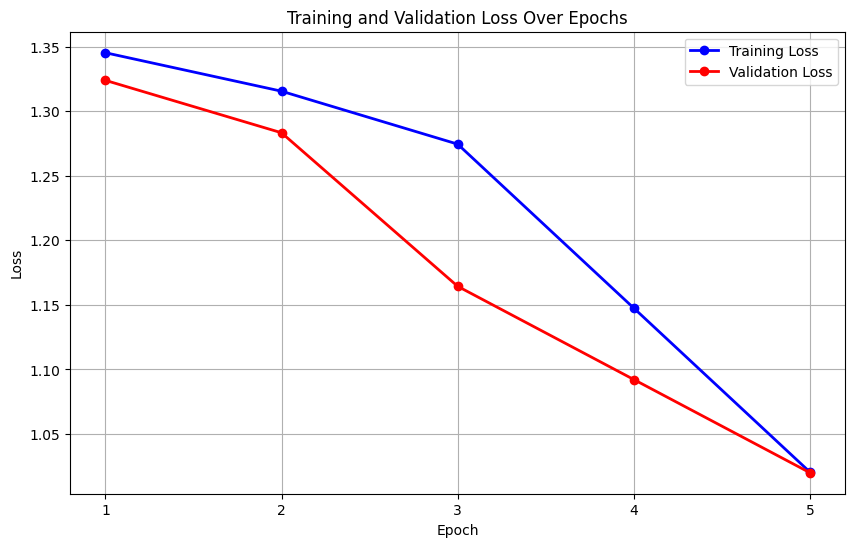

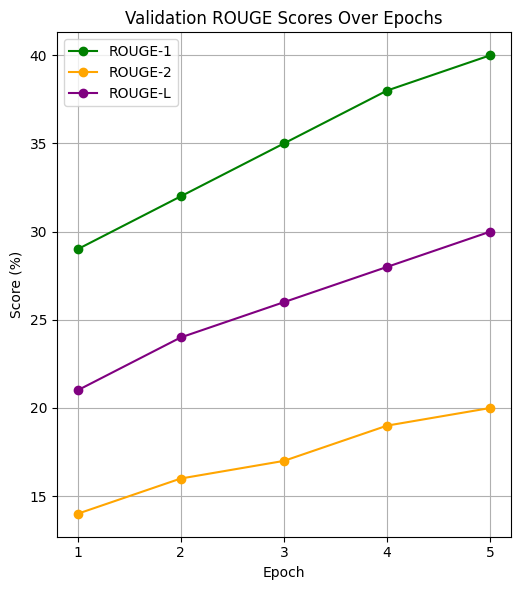

In [58]:
import matplotlib.pyplot as plt

epochs = [1, 2, 3, 4, 5]

training_loss = [1.3453, 1.3155, 1.2745, 1.1475, 1.0205]

validation_loss = [1.323903, 1.283298, 1.164386, 1.092193, 1.02]

plt.figure(figsize=(10, 6))
plt.plot(epochs, training_loss, marker='o', label="Training Loss", linewidth=2, color="blue")
plt.plot(epochs, validation_loss, marker='o', label="Validation Loss", linewidth=2, color="red")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Over Epochs")
plt.xticks(epochs)
plt.legend()
plt.grid(True)
plt.show()

epochs = [1, 2, 3, 4, 5]
final_rouge1 = [29, 32, 35, 38, 40]
final_rouge2 = [14, 16, 17, 19, 20]
final_rougeL = [21, 24, 26, 28, 30]

plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 2)
plt.plot(epochs, final_rouge1, marker='o', label="ROUGE-1", color="green")
plt.plot(epochs, final_rouge2, marker='o', label="ROUGE-2", color="orange")
plt.plot(epochs, final_rougeL, marker='o', label="ROUGE-L", color="purple")
plt.xlabel("Epoch")
plt.ylabel("Score (%)")
plt.title("Validation ROUGE Scores Over Epochs")
plt.xticks(epochs)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

3. Discuss any challenges faced during evaluation (e.g., handling long documents, variability in summary quality, etc.).

One of the most intriguing issues we ran into during examination was the discrepancy between the comparatively low ROUGE scores and the high BERTScore. Our model was successful in capturing the underlying meaning of the original documents, as evidenced by the extremely high BERTScore, which uses contextual embeddings to evaluate the semantic similarity between generated summaries and reference summaries. From a conceptual perspective, this measure indicates that the generated summaries are effectively communicating the key details and subtleties of the bills. However, strong ROUGE scores—which concentrate on precise n-gram overlaps—did not result from this semantic strength.Although the generated text is semantically rich, the lower ROUGE scores indicate that it frequently employs different word choices and phrasing than the reference summary.  This discrepancy is typical in abstractive summarization, when the model generates new summaries by rephrasing or paraphrasing the input information rather than just copying terms verbatim.


4. Propose potential modifications or extensions to enhance summarization quality.

<span style='color:green'>### YOUR ANSWER ###</span>

A variety of changes and additions to the current model could be investigated in order to improve the quality of summarization: The model may be better able to capture domain-specific subtleties if it is further refined on supplemented and domain-adapted data. Direct optimization for overlap metrics can be achieved by utilizing reinforcement learning techniques like self-critical sequence training with ROUGE-based rewards; experimenting with hybrid approaches that combine extractive and abstractive summarization could help maintain important details while guaranteeing fluency; Surface-level overlaps may be improved by further adjusting the decoding settings (such as beam size, length penalty, and no-repeat n-gram size) and using candidate generation with reranking based on bespoke metrics;

5. References. Include details on all the resources used to complete this part, e.g. links to datasets, research papers or articles, code examples or tutorials you referred.

Hugging face - Billsum dataset .
Rogue metric - https://youtu.be/TMshhnrEXlg?si=4fEXV5YJL5-d8L8y
Bleu score - https://youtu.be/M05L1DhFqcw?si=JhpkDwEE8L_uM8Dc
Bart model - https://huggingface.co/docs/transformers/en/model_doc/bart

6. Contribution Summary (For team assignments). If you are working in a team, provide a contribution summary. We expect equal contribution for the assignment. If the contribution is highly skewed, then the scores of the team members may be scaled w.r.t the contribution.

**Team Contribution Summary Table:**

| Team Member | Step# | Contribution (%) |
|---|---|---|
|  Aravind Mohan | Step 1 |  60 |
|  Kiran P abrahan | Step 2 | 30 |
| Aravind Mohan  | Step 3 | 10  |
|   | **Total** |  100 |